## 9.1 门控循环单元(GRU)
在8.7节中，我们讨论了如何在循环神经网络中计算梯度，以及矩阵连续乘积可以导致梯度消失或梯度爆炸的问题。下面我们简单思考一下这种梯度异常在实践中的意义：
- 我们可能会遇到这样的情况：早期观测值对预测所有未来观测值具有非常重要的意义。考虑一个极端情况，其中第一个观测值包含一个校验和，目标是在序列的末尾辨别校验和是否正确。在这种情况下，第一个词元的影响至关重要。我们希望有某些机制能够在一个记忆元里存储重要的早期信息。如果没有这样的机制，我们将不得不给这个观测值指定一个非常大的梯度，因为它会影响所有后续的观测值。
- 我们可能会遇到这样的情况：一些词元没有相关的观测值。例如，在对网页内容进行情感分析时，可能有一些辅助HTML代码与网页传达的情绪无关。我们希望有一些机制来跳过隐状态表示中的此类词元。
- 我们可能会遇到这样的情况：序列的各个部分之间存在逻辑中断。例如，书的章节之间可能会有过度存在，或者证券的熊市和牛市之间可能会存在过渡。在这种情况下，最好有一种方法来重置我们的内部状态表示。

在学术界已经提出了许多方法来解决这类问题。其中最早的方法是“长短期记忆”(long-short-term memory, LSTM)，我们将在9.2节中讨论。门控循环单元(gated recurrent unit, GRU)是一个稍微简化的变体，通常能够提供同等的效果，并且计算的速度明显更快。由于门控循环单元更简单，我们从它开始解读。


### 9.1.1 门控隐状态
门控循环单元与普通的循环神经网络之间的关键区别在于：后者支持隐状态的门控。这意味着模型有专门的机制来确定应该何时更新状态，以及应该何时重置隐状态。这些机制是可学习的，并且能够解决了上面列出的问题。例如，如果第一个词元非常重要，模型将学会在第一次观测之后不更新隐状态。同样，模型也可以学会跳过不相关的临时观测。最后，模型还将学会在需要的时候重置隐状态。下面我们将详细讨论各类门控。

**重置门和更新门**

我们首先介绍重置门(reset gate)和更新门(update gate)。我们把它们设计成(0, 1)区间中的向量，这样我们就可以进行凸组合。重置门允许我们控制“可能还想记住”的过去状态的数量；更新门将允许我们控制新状态中有多少个旧状态的副本。

我们从构造这些门控开始。图9.1.1描述了门控循环单元的重置门和更新门的输入，输入是由当前时间步的输入和前一时间步的隐状态给出。两个门的输出是由使用sigmoid激活函数的两个全连接层给出。

<div align=center>
<img src='../../pics/9_1_1.jpeg' width='50%'>
</div>

我们来看一下门控循环单元的数学表达。对于给定的时间步t，假设输入是一个小批量$X_t \in \mathbb R^{n \times d}$(样本个数：n，输入个数：d)，上一个时间步的隐状态是$H_{t-1} \in \mathbb R^{n \times h}$(隐藏单元个数：h)。那么，重置门$R_t \in \mathbb R^{n \times h}$和更新门$Z_t \in \mathbb R^{n \times h}$的计算如下式：
$$
R_t = \sigma (X_t W_{xr} + H_{t-1} W_{hr} + b_r)\\
Z_t = \sigma (X_t W_{xz} + H_{t-1} W_{hz} + b_z)
\tag{9.1.1}
$$

其中$W_{xr}, W_{xz} \in \mathbb R^{d \times h}$和$W_{hr}, W_{hz} \in \mathbb R^{h \times h}$是权重参数，$b_r, b_z \in \mathbb R^{1 \times h}$是偏置参数。请注意，在求和过程中会触发广播机制。我们使用sigmoid函数将输入值转换到区间(0, 1)。

**候选隐状态**

接下来，让我们将重置门$R_t$与(8.4.5)中的常规状态更新机制集成，得到在时间步t的候选隐状态(candidate hidden state)$\tilde H_t \in \mathbb R^{n \times h}$。
$$
\tilde H_t = tanh(X_t W_{xh} + (R_t \odot H_{t-1}) W_{hh} + b_h)
\tag{9.1.2}
$$

其中$W_{xh} \in \mathbb R^{d \times h}$和$W_{hh} \in \mathbb R^{h \times h}$是权重参数，$b_h \in \mathbb R^{1 \times h}$是偏置项，符号$\odot$是Hadamard积(按元素乘积)运算符。在这里，我们使用tanh非线形激活函数来确保候选隐状态中的值保持在区间(-1, 1)中。

与(8.4.5)相比，(9.1.2)中的$R_t$和$H_{t-1}$的元素相乘可以减少以往状态的影响。每当重置门$R_t$中的项接近1时，我们恢复一个如(8.4.5)中的普通的循环神经网络。对于重置门$R_t$中所有接近0的项，候选隐状态是以$X_t$作为输入的多层感知机的结果。因此，任何预先存在的隐状态都会被重置为默认值。

图9.1.2说明了应用重置门之后的计算流程
<div align=center>
<img src='../../pics/9_1_2.jpeg' width='50%'>
</div>

**隐状态**

上述的计算结果只是候选隐状态，我们仍然需要结合更新门$Z_t$的效果。这一步确定新的隐状态$H_t \in \mathbb R^{n \times h}$在多大程度上来自旧的状态$H_{t-1}$和新的候选状态$\tilde H_t$。更新门$Z_t$仅需要在$H_{t-1}$和$\tilde H_t$之间进行按元素的凸组合就可以实现这个目标。这就得出了门控循环单元的最终更新公式：
$$
H_t = Z_t \odot H_{t-1} + (1 - Z_t) \odot \tilde H_t
$$

每当更新$Z_t$接近1时，模型就倾向只保留旧状态。此时，来自$Z_t$的信息基本上被忽略，从而有效地跳过了依赖链条中的时间步t。相反，当$Z_t$接近0时，新的隐状态$H_t$就会接近候选隐状态$\tilde H_t$。这些设计可以帮助我们处理循环神经网络中的梯度消失问题，并更好地捕获时间步距离很长的序列的依赖关系。例如，如果整个子序列的所有时间步的更新门都接近于1，则无论序列的长度如何，在序列起始时间步的旧隐状态都将很容易保留并传递到序列结束。

图9.1.3说明了更新门起作用后的计算流
<div align=center>
<img src='../../pics/9_1_3.jpeg' width='50%'>
</div>

总之，门控循环单元具有以下两个显著特征：
- 重置门有助于捕获序列中的短期依赖关系
- 更新门有助于捕获序列中的长期依赖关系


### 9.1.2 从零开始实现
为了更好地理解门控循环单元模型，我们从零开始实现它。首先，我们读取8.5节中使用的时间机器数据集：

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

**初始化模型参数**

下一步是初始化模型参数。我们从标准差为0.01的高斯分布中提取权重，并将偏置项设为0，超参数`num_hiddens`定义隐藏单元的数量，实例化与更新门、重置门、候选隐状态和输出层相关的所有权重和偏置。

In [7]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01

    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xz, W_hz, b_z = three()  # 更新门参数
    W_xr, W_hr, b_r = three()  # 重置门参数
    W_xh, W_hh, b_h = three()  # 候选隐状态参数
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

**定义模型**

现在我们将定义隐状态的初始化函数`init_gru_state`。与8.5节中定义的`init_rnn_state`函数一样，此函数返回一个形状为(批量大小,隐藏单元数)的张量，张量的值全部为0

In [8]:
def init_gru_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

现在我们准备定义门控循环单元模型，模型的架构与基本的循环神经网络单元是相同的，只是更新权重公式更为复杂。

In [9]:
def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        Z = torch.sigmoid((X @ W_xz) + (H @ W_hz) + b_z)
        R = torch.sigmoid((X @ W_xr) + (H @ W_hr) + b_r)
        H_tilda = torch.tanh((X @ W_xh) + ((R * H) @ W_hh) + b_h)
        H = Z * H + (1 - Z) * H_tilda
        Y = H @ W_hq + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

**训练与预测**

训练和预测的工作方式与8.5节完全相同。训练结束后，我们分别打印输出训练集的困惑度，以及前缀“time traveler”和“traveler”的预测序列上的困惑度。

perplexity 1.1, 17570.7 tokens/sec on cpu
time traveller but now you begin to seethe object of my investig
travelleryou can show black is white by argument said filby


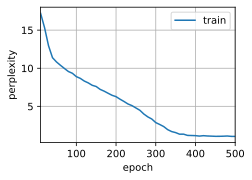

In [10]:
vocab_size, num_hiddens = len(vocab), 256
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, 'cpu', get_params,
                            init_gru_state, gru)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, 'cpu')

### 9.1.3 简洁实现
高级API包含了前文介绍的所有配置细节，所以我们可以直接实例化门控循环单元模型。这段代码的运行速度要快的多，因为它使用的是编译好的运算符而不是Python实现的。

perplexity 1.0, 20637.5 tokens/sec on cpu
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


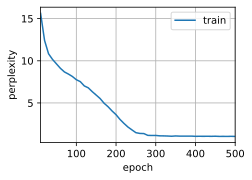

In [11]:
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = d2l.RNNModel(gru_layer, len(vocab))
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, 'cpu')

### 9.1.4 小结
- 门控循环神经网络可以更快地捕获时间步距离很长的序列上的依赖关系
- 重置门有助于捕获序列中的短期依赖关系
- 更新门有助于捕获序列中的长期依赖关系
- 重置门打开时，门控循环单元包含基本循环神经网络；更新门打开时，门控循环单元可以跳过子序列